In [1]:
#HIDE
try:
    import setup
except:
    pass
from notebook_helper import *
notebook_setup()
from modules import la

# Composite IMD distance calculation

This notebook generates distance calculations and labels based on IMD scores for specific LSOAs, based on the [uk composite](https://github.com/mysociety/composite_uk_imd).

This works in two ways, labels are produced by creating overall scores for each authority via the method for creating scores for higher geographies. Labels for county/combined are generated by putting them into the deciles as worked out by the lower geographies (so the original deciles are not affected by counting lots of the population twice).

The actual distance works by creating three values for authority - the percentage of pop that lives in the 1, 2-3, and 4-5 deciles. 
This creates distance measures that are a bit more sensitive to different kinds of mixes of deprivation.

In [2]:
# bring in the uk-wide imd info

# split into three dimensions, decile 1 is high, 2,3 is medium, 4,5 is low.

imd = pd.read_csv(Path("data", "source", "UK_IMD_E.csv")).set_index("lsoa")
imd = imd[["UK_IMD_E_pop_quintile"]].rename(columns={"UK_IMD_E_pop_quintile":"quintile"})
imd["group"] = imd["quintile"].map({1:"High deprivation", 2:"Medium deprivation", 3: "Medium deprivation", 4:"Low deprivation", 5:"Low deprivation"})
imd

ruc = pd.read_csv(Path("data", "source", "composite_ruc.csv")).set_index("lsoa")[["pop"]]
imd = imd.join(ruc)
imd

,quintile,group,pop
lsoa,,,
E01021988,1,High deprivation,2091
W01000240,1,High deprivation,1629
E01012673,1,High deprivation,1406
E01012681,1,High deprivation,1525
E01012672,1,High deprivation,1463
...,...,...,...
S01006573,5,Low deprivation,761
S01008066,5,Low deprivation,912
S01008861,5,Low deprivation,769


In [3]:
# get this into the form of a sheet where the percentage of each lower-tier la in different deprivation bands is in different columns
df = pd.read_csv(Path("data", "source", "lsoa_la_2021.csv")).set_index("lsoa")
df = imd.join(df, how="outer")
pt = df.pivot_table("pop", index="local-authority-code", columns=["group"], aggfunc="sum").fillna(0)

# add higher levels
hpt = pt.la.to_multiple_higher(aggfunc="sum").set_index("local-authority-code")
pt = pd.concat([pt, hpt])

# adding density in as another factor to pill apart similar deprivations
pt = pt.common.row_percentages().la.add_info(["pop-2020", "area"])
pt["density"] = pt["area"] / pt["pop-2020"]
pt = pt.drop(columns=["area", "pop-2020"])
pt

,High deprivation,Low deprivation,Medium deprivation,density
local-authority-code,,,,
ABC,0.19,0.00,0.81,6.16e-03
ABD,0.03,0.74,0.23,2.42e-02
ABE,0.09,0.57,0.34,8.12e-04
ADU,0.02,0.51,0.47,6.54e-04
AGB,0.08,0.46,0.46,8.08e-02
...,...,...,...,...
NTCA,0.26,0.36,0.38,6.21e-03
TVCA,0.40,0.32,0.28,1.17e-03
WECA,0.16,0.51,0.34,1.00e-03


In [4]:
df = (pt
      .space.self_distance("local-authority-code", ["Low deprivation", "Medium deprivation", "High deprivation", "density"], normalize=True)
      .space.match_distance()
      .space.local_rankings()
      .sort_values("distance"))

df.to_csv(Path("data", "outputs", "imd", "distance_map.csv"), index=False)
df.head()

,local-authority-code_A,local-authority-code_B,distance,match,position
46920,ELM,FAR,0.01,99.8,1.0
53040,FAR,ELM,0.01,99.8,1.0
88536,MOL,TAN,0.01,99.7,1.0
141168,TAN,MOL,0.01,99.7,1.0
53041,FAR,EPS,0.02,99.6,2.0


# Making labels for group

Usually we'd try and work this out from clusters, but there's a good alternative idea for IMD.

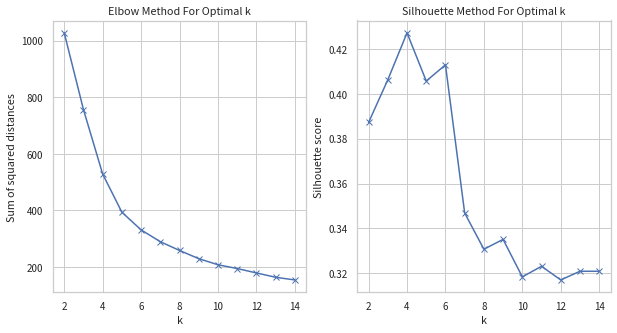

In [5]:
# now look to see if obvious clusters
c = pt.space.cluster()
c.find_k()

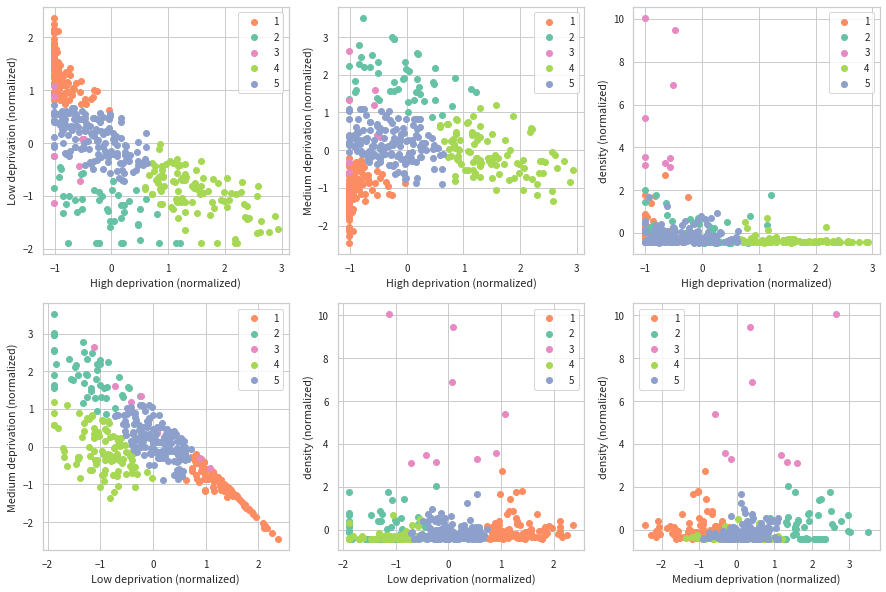

In [6]:
c.set_k(5).plot()

These are goodish clusters, but are hard to describe in an easy way. Think the best approach for labels is to calculate the overall ranking, split into quintiles, and use those as the labels (already understood terminology), while the distance will present more subtle useful comparisons.

In [7]:
# This follows methodology in https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833947/IoD2019_Research_Report.pdf p. 69

lookup = pd.read_csv(
    Path("data", "source", "lsoa_la_2021.csv")).set_index("lsoa")

# merge lsoa to la lookup column
df = pd.read_csv(Path("data","imd", "UK_IMD_E.csv")).set_index("lsoa")
df = df.join(lookup)

# merge lsoa population in
pop = pd.read_csv(Path("data", "imd", "2019_population.csv"), thousands=",").set_index("lsoa")
df = df.join(pop)

# create a population adjusted score
df["pop_score"] = df["UK_IMD_E_score"] * df["pop"]

# pivot up to the local authority level
pt = df.pivot_table(["pop_score","pop"], index="local-authority-code", aggfunc="sum")

# combine these for the higher level authorities
pt = pt.reset_index()
higher_df = pt.la.to_multiple_higher(aggfunc="sum")

# calculate a new score, dividing the summed score by the summed population
pt["la_deprivation_score"] = pt["pop_score"] / pt["pop"]
higher_df["la_deprivation_score"] = higher_df["pop_score"] / higher_df["pop"]

# at this point we're calculating population quintiles based on lower tiers
df = pt.sort_values("la_deprivation_score", ascending=False)
df["cum_pop"] = df["pop"].astype("int").cumsum()
df["la_imd_pop_quintile"] = np.ceil(
    df["cum_pop"]/sum(df["pop"]) * 5).astype(int)
df = df.drop(columns=["pop", "pop_score", "cum_pop"])

# now we slot in the higher tiers into the quintiles already established
higher_df["la_imd_pop_quintile"] = 0
pt = pd.concat([df, higher_df]).sort_values("la_deprivation_score", ascending=False).set_index("local-authority-code")
last_quin = 1
for i, row in pt.iterrows():
    if row["la_imd_pop_quintile"] == 0:
        pt.loc[i, "la_imd_pop_quintile"] = last_quin
    else:
        last_quin = row["la_imd_pop_quintile"]

pt

,la_deprivation_score,la_imd_pop_quintile,pop,pop_score
local-authority-code,,,,
BPL,45.49,1.0,NaN,NaN
KWL,43.17,1.0,NaN,NaN
LIV,42.54,1.0,NaN,NaN
KHL,40.63,1.0,NaN,NaN
MDB,40.38,1.0,NaN,NaN
...,...,...,...,...
MSS,7.74,5.0,NaN,NaN
WAE,7.51,5.0,NaN,NaN
RUS,7.20,5.0,NaN,NaN


In [8]:
# get the quintiles as labels

def num_to_ith(num: Union[float, int]) -> str:
    """1 becomes 1st, 2 becomes 2nd, etc."""
    value             = str(num)
    before_last_digit = 0
    last_digit        = value[-1]
    if len(value) > 1 and before_last_digit == '1': return value +'th'
    if last_digit == '1': return value + 'st'
    if last_digit == '2': return value + 'nd'
    if last_digit == '3': return value + 'rd'
    return value + 'th'

def label_quintile(v: float) -> str:
    label = f"{num_to_ith(int(v))} IMD quintile"
    return label

df = pt.reset_index()[["local-authority-code","la_imd_pop_quintile"]]

df["label"] = df["la_imd_pop_quintile"].apply(label_quintile)
df = df.drop(columns=["la_imd_pop_quintile"])
df.to_csv(Path("data", "outputs", "imd", "la_labels.csv"), index=False)

In [9]:
# make the label description

df = pd.Series(df["label"].unique()).to_frame().rename(columns={0: "label"})

df["desc"] = ["Councils in most deprived quintile (20%)",
              "Councils in second most deprived quintile (20%)",
              "Councils in middle deprivation quintile (20%)",
              "Councils in second least deprived quintile (20%)",
              "Councils in least deprived quintile (20%)"]

df.to_csv(Path("data", "outputs", "imd", "label_desc.csv"), index=False)